<a href="https://colab.research.google.com/github/VKSi/2021_02_GB_PyTorch/blob/main/HW_5_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> “Фреймворк PyTorch для разработки искусственных нейронных сетей”</center></h1>

In [ ]:
skip_preparations = True

In [ ]:
!pip install opencv-python opencv-contrib-python

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/PyTorch/'
PATH_L5 = PATH + 'Lesson5/'
DATA_PATH = PATH + 'data/leapGestRecog/'

In [ ]:
import os
import cv2
from zipfile import ZipFile
from PIL import Image
import numpy as np
import pandas as pd
import seaborn
import math

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch
from torch import optim
from torch.nn import functional as F

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

## Функции из предоставленного ноутбука   

In [ ]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Знакомство с датасетом

In [ ]:
os.listdir(DATA_PATH)

['08', '07', '09', '00', '01', '02', '05', '03', '04', '06']

In [ ]:
sorted(os.listdir(DATA_PATH + '00'))

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [ ]:
sorted(os.listdir(DATA_PATH + '07'))

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [ ]:
os.listdir(DATA_PATH + '07/01_palm/')[:7]

['frame_07_01_0005.png',
 'frame_07_01_0025.png',
 'frame_07_01_0080.png',
 'frame_07_01_0061.png',
 'frame_07_01_0040.png',
 'frame_07_01_0058.png',
 'frame_07_01_0018.png']

In [ ]:
os.listdir(DATA_PATH + '08/05_thumb/')[:7]

['frame_08_05_0030.png',
 'frame_08_05_0010.png',
 'frame_08_05_0014.png',
 'frame_08_05_0003.png',
 'frame_08_05_0023.png',
 'frame_08_05_0017.png',
 'frame_08_05_0032.png']

В описании сказано, что первый уровень директорий разделяет субъектов ("актёров"). Нас это разделение не интересует, мы можем от него избавиться.     
Такде видно, что названия файлов пронумеррованы в соответствии с иерархией лиректорий. Мы можем смело смешивать их а одну кучу и получать лейблы из названия как int(filename[9:11])

## Смотрим примеры картинок и пишем Dataset

In [ ]:
GESTURE_PATHS = sorted(os.listdir(DATA_PATH + '00'))
GESTURE_LABELS = {g[:2]:g[3:] for g in GESTURE_PATHS}
GESTURE_LABELS

{'01': 'palm',
 '02': 'l',
 '03': 'fist',
 '04': 'fist_moved',
 '05': 'thumb',
 '06': 'index',
 '07': 'ok',
 '08': 'palm_moved',
 '09': 'c',
 '10': 'down'}

In [ ]:
if not skip_preparations:
  for i in range(10):
    actor = np.random.randint(0, 10)
    gesture = np.random.randint(0, 10)
    direct_path = DATA_PATH + f'0{actor}/' + f'{GESTURE_PATHS[gesture]}/'
    im_names = os.listdir(direct_path)
    image_n = np.random.randint(0, len(im_names))
    image = Image.open(direct_path + im_names[image_n])
    plt.imshow(image)
    plt.title(f'{GESTURE_PATHS[gesture]}'[3:])
    plt.show()

In [ ]:
if not skip_preparations:
  for actor in range(10):
    print('*'*10)
    print(actor)
    print('*'*10)
    for gesture in range(10):
        direct_path = DATA_PATH + f'0{actor}/' + f'{GESTURE_PATHS[gesture]}/'
        print(direct_path, ' : ', len(os.listdir(direct_path)))

Видно, что в каждой папке по 200 картинок. Это можно было бы использовать, но для большей универсаотности все-таки в процессе иннициации бу
дем сохранять пути к файлам

### Пропустить, если таблица уже создана

In [ ]:
if not skip_preparations:
  paths = []
  for actor in range(10):
    for gesture in range(10):
        direct_path = DATA_PATH + f'0{actor}/' + f'{GESTURE_PATHS[gesture]}/'
        im_names = os.listdir(direct_path)
        for im_name in im_names:
          paths.append(direct_path + im_name)
  paths[42]

In [ ]:
if not skip_preparations:
  data_info = pd.DataFrame({'paths': paths})
  data_info['label'] = data_info.paths.str[-11:-9].astype(int) - 1
  data_info.tail()

In [ ]:
if not skip_preparations:
  data_info.to_csv(PATH_L5 + 'data_info.csv')

### Работаем дальше, загружая данные из таблицы

In [ ]:
data_info = pd.read_csv(PATH_L5 + 'data_info.csv', index_col=0)
data_info

,paths,label
0,gdrive/My Drive/AI/GB/PyTorch/data/leapGestRec...,0
1,gdrive/My Drive/AI/GB/PyTorch/data/leapGestRec...,0
2,gdrive/My Drive/AI/GB/PyTorch/data/leapGestRec...,0
3,gdrive/My Drive/AI/GB/PyTorch/data/leapGestRec...,0
4,gdrive/My Drive/AI/GB/PyTorch/data/leapGestRec...,0
...,...,...
19995,gdrive/My Drive/AI/GB/PyTorch/data/leapGestRec...,9
19996,gdrive/My Drive/AI/GB/PyTorch/data/leapGestRec...,9
19997,gdrive/My Drive/AI/GB/PyTorch/data/leapGestRec...,9
19998,gdrive/My Drive/AI/GB/PyTorch/data/leapGestRec...,9


Пройдем путь преобразования на одном изображении

In [ ]:
index = 42
# ---------------------------------------------------
image = Image.open(data_info.loc[index, 'paths'])
print(type(image))
print(image.size)
# ---------------------------------------------------
image = image.resize((64, 64))
print(image.size)
# ---------------------------------------------------
image = np.asarray(image).astype('float')
print(type(image))
print(image.shape)
print(image[42][42:])
# ---------------------------------------------------
image = torch.as_tensor(image)/255
print(type(image))
print(image.shape)
print(image[42][42:])
# ---------------------------------------------------
image = image.unsqueeze(0)
print(type(image))
print(image.shape)
print(image[0][42][42:])

<class 'PIL.PngImagePlugin.PngImageFile'>
(640, 240)
(64, 64)
<class 'numpy.ndarray'>
(64, 64)
[247. 245. 242. 231. 208. 110.  34.  34.  29.  24.  17.  11.  10.  10.
  10.   8.   9.  10.  10.  10.  10.  10.]
<class 'torch.Tensor'>
torch.Size([64, 64])
tensor([0.9686, 0.9608, 0.9490, 0.9059, 0.8157, 0.4314, 0.1333, 0.1333, 0.1137,
        0.0941, 0.0667, 0.0431, 0.0392, 0.0392, 0.0392, 0.0314, 0.0353, 0.0392,
        0.0392, 0.0392, 0.0392, 0.0392], dtype=torch.float64)
<class 'torch.Tensor'>
torch.Size([1, 64, 64])
tensor([0.9686, 0.9608, 0.9490, 0.9059, 0.8157, 0.4314, 0.1333, 0.1333, 0.1137,
        0.0941, 0.0667, 0.0431, 0.0392, 0.0392, 0.0392, 0.0314, 0.0353, 0.0392,
        0.0392, 0.0392, 0.0392, 0.0392], dtype=torch.float64)


                l


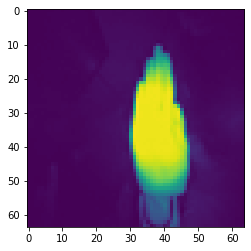

In [ ]:
def output_im_show(output_im, label):
  label_str = (f'0{label + 1}', '10')[int(label == 10)]
  print(' '*15, GESTURE_LABELS[label_str])
  plt.imshow(output_im.squeeze(0).numpy())

output_im_show(image, 1)

In [ ]:
class CustomDatasetFromImages(Dataset):
    
    def __init__(self, data_info: pd.DataFrame, preprocessing=None):
      self.data = data_info.reset_index(drop=True)
      self.data_len = self.data.shape[0]     
      self.preprocessing = preprocessing

    def __getitem__(self, index):
      image = Image.open(self.data.loc[index, 'paths'])
      label = self.data.loc[index, 'label']

      image = image.resize((64,64))
      image = np.asarray(image).astype('float')

      if self.preprocessing:
        image = self.preprocessing(image)
      image = torch.as_tensor(image)/255
      image = image.unsqueeze(0)
      return (image.float(), label)

    def __len__(self):
        return self.data_len

In [ ]:
data = CustomDatasetFromImages(data_info)

Проверим что размерность изображения и его значения соответствуют тому, что нам надо

torch.Size([1, 64, 64])
                palm


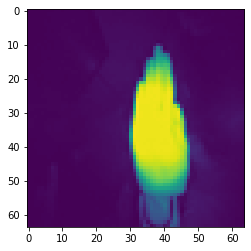

In [ ]:
image, label = data.__getitem__(42)

print(image.size())
output_im_show(image, label)

torch.Size([1, 64, 64])
                l


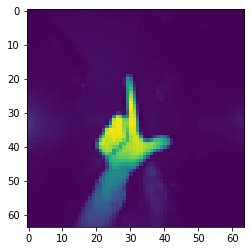

In [ ]:
image, label = data[4321] # get some sample
print(image.size())
output_im_show(image, label)

## Обучение

In [ ]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 25 - в тестовую
X_train, X_test = train_test_split(data_info, test_size=0.25)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)  # 30x30x6 -> 13x13x16
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64x64 x1 -> 60x60 x6 -> 30x30 x6
        x = self.pool(F.relu(self.conv2(x)))  # 30x30 x6 -> 26x26 x16 -> 13x13 x16
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
net = Net().to(device)

In [ ]:
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def metrics(_net, _t_loader, label):
  counter_pos = 0
  counter_tot = 0
  for i, data in enumerate(_t_loader, 0):
    inputs, labels = data[0], data[1]
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = _net(inputs)
    for j in range(len(labels)):
      counter_tot += 1
      counter_pos += int(outputs[j].argmax() == labels[j])
  result = np.floor(counter_pos/counter_tot*100)/10
  print(f'На сете {label} правильно предсказано {result} из 10')
  return result

def metrics_train_test(_net, _train_loader, _test_loader):
  return metrics(_net=_net, _t_loader=_train_loader, label='train'), metrics(_net=_net, _t_loader=_test_loader, label='test')

In [ ]:
def learning(net, _train_loader, _optimizer,  _criterion):
  for epoch in range(10):  # 10 эпох 
    running_loss = 0.0 # Для вывода процесса обучения
    for i, data in enumerate(_train_loader, 0):
        inputs, labels = data[0], data[1]
        inputs, labels = inputs.to(device), labels.to(device)
        # Обнуляем градиент
        _optimizer.zero_grad()
    
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = _criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 200 == 0:    # печатаем каждые 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    torch.save(net.state_dict(), PATH_L5 + f'net_e10_{epoch}.pth')
  print('Training is finished!')
  return net

In [ ]:
net = learning(net, train_loader, optimizer,  criterion)
torch.save(net.state_dict(), PATH_L5 + 'net_e10_2nd.pth')

[1,     1] loss: 0.012
[1,   201] loss: 2.297
[1,   401] loss: 2.288
[1,   601] loss: 2.230
[1,   801] loss: 1.776
[2,     1] loss: 0.004
[2,   201] loss: 0.835
[2,   401] loss: 0.565
[2,   601] loss: 0.389
[2,   801] loss: 0.348
[3,     1] loss: 0.000
[3,   201] loss: 0.241
[3,   401] loss: 0.225
[3,   601] loss: 0.169
[3,   801] loss: 0.104
[4,     1] loss: 0.000
[4,   201] loss: 0.050
[4,   401] loss: 0.061
[4,   601] loss: 0.053
[4,   801] loss: 0.041
[5,     1] loss: 0.000
[5,   201] loss: 0.028
[5,   401] loss: 0.037
[5,   601] loss: 0.013
[5,   801] loss: 0.026
[6,     1] loss: 0.000
[6,   201] loss: 0.030
[6,   401] loss: 0.008
[6,   601] loss: 0.011
[6,   801] loss: 0.008
[7,     1] loss: 0.000
[7,   201] loss: 0.017
[7,   401] loss: 0.016
[7,   601] loss: 0.016
[7,   801] loss: 0.043
[8,     1] loss: 0.000
[8,   201] loss: 0.026
[8,   401] loss: 0.009
[8,   601] loss: 0.005
[8,   801] loss: 0.007
[9,     1] loss: 0.000
[9,   201] loss: 0.001
[9,   401] loss: 0.006
[9,   601] 

In [ ]:
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

На сете train правильно предсказано 9.9 из 10
На сете test правильно предсказано 9.9 из 10


Text(0.5, 68.09375, 'Predicted label')

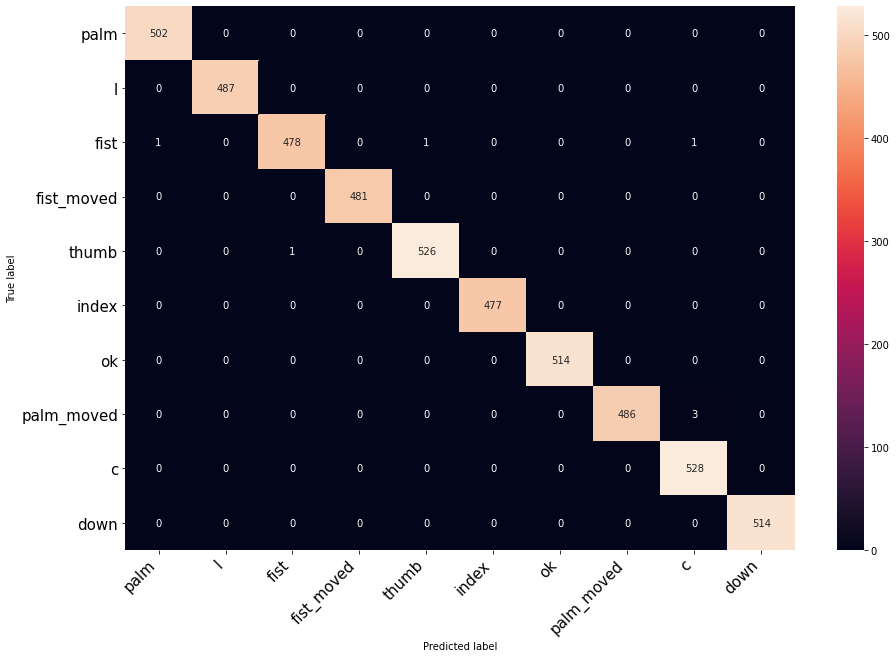

In [ ]:
confusion_matrix = torch.zeros(10, 10)

with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        for j in range(outputs.shape[0]):
          guessed_label = outputs[j].argmax().item()
          truth_label = labels[j]
          confusion_matrix[guessed_label, truth_label] += 1

plt.figure(figsize=(15,10))

class_names = [v for v in GESTURE_LABELS.values()]
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = seaborn.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
net_loaded = Net().to(device)

In [ ]:
net_loaded.load_state_dict(torch.load(PATH_L5 + 'net_e10_2nd.pth'))
# net.eval()

<All keys matched successfully>

Text(0.5, 68.09375, 'Predicted label')

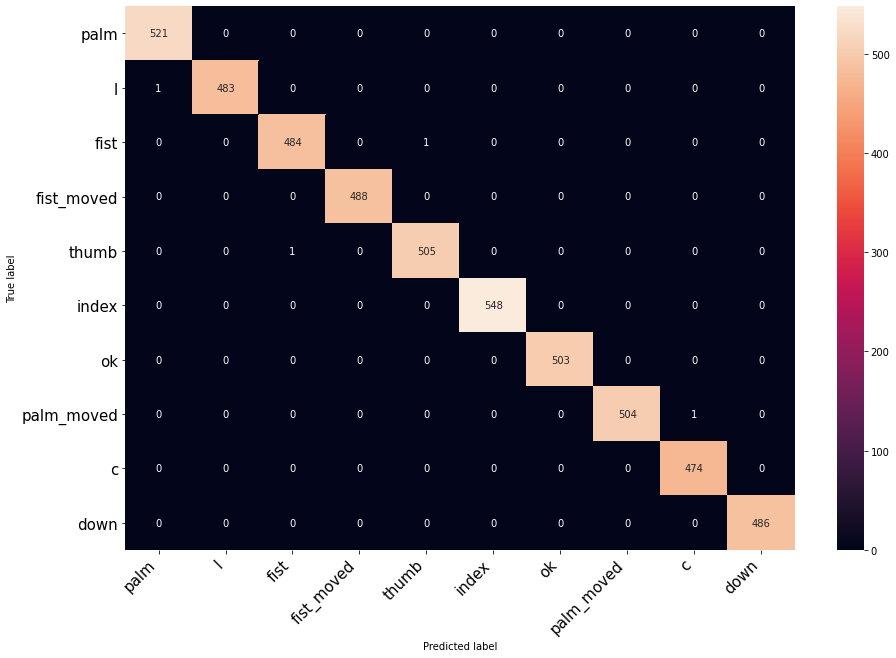

In [ ]:
confusion_matrix = torch.zeros(10, 10)

with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net_loaded(images)
        for j in range(outputs.shape[0]):
          guessed_label = outputs[j].argmax().item()
          truth_label = labels[j]
          confusion_matrix[guessed_label, truth_label] += 1

plt.figure(figsize=(15,10))

class_names = [v for v in GESTURE_LABELS.values()]
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = seaborn.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

torch.Size([4, 1, 64, 64])
torch.Size([4, 10])


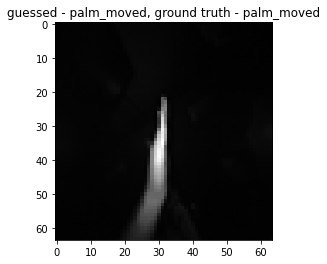

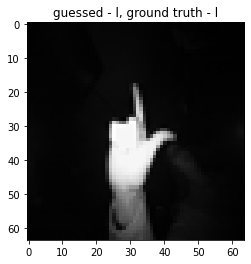

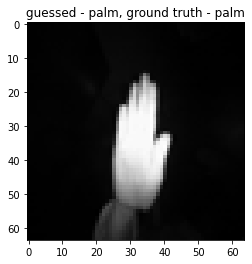

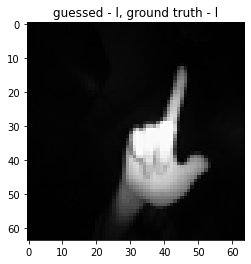

torch.Size([4, 1, 64, 64])
torch.Size([4, 10])


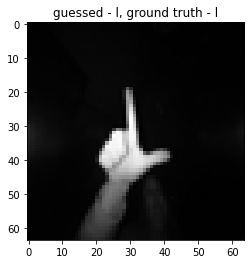

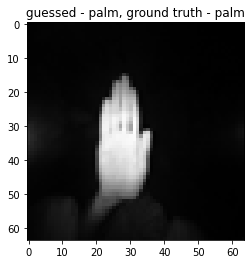

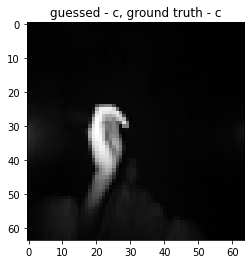

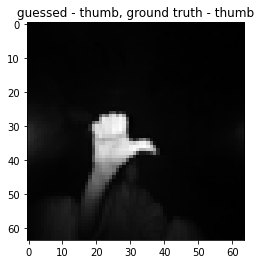

torch.Size([4, 1, 64, 64])
torch.Size([4, 10])


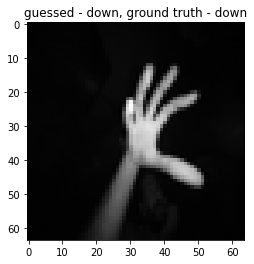

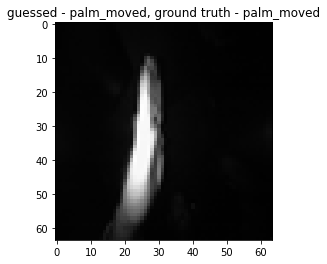

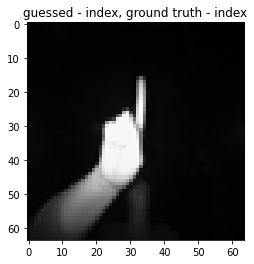

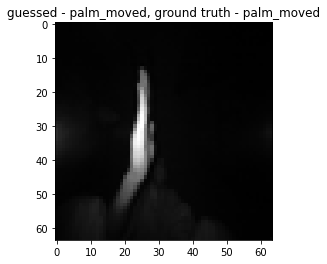

torch.Size([4, 1, 64, 64])
torch.Size([4, 10])


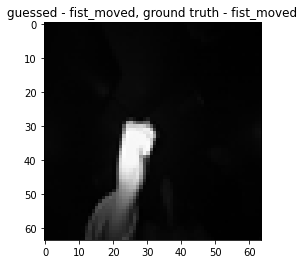

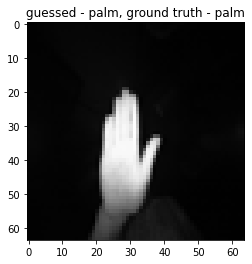

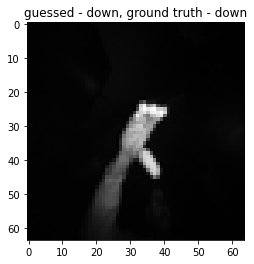

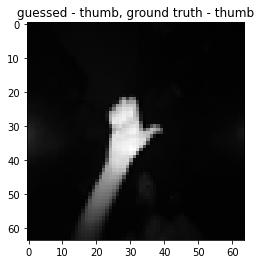

torch.Size([4, 1, 64, 64])
torch.Size([4, 10])


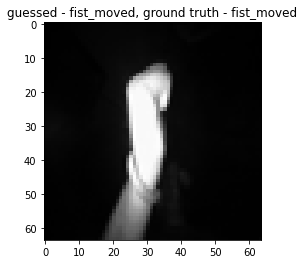

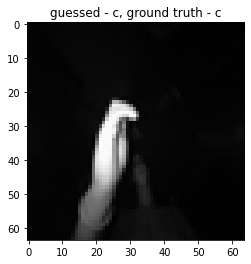

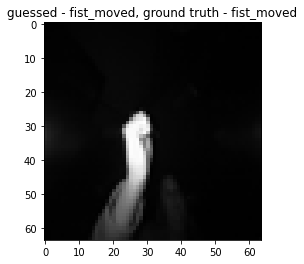

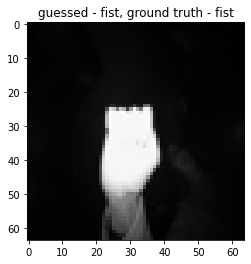

torch.Size([4, 1, 64, 64])
torch.Size([4, 10])


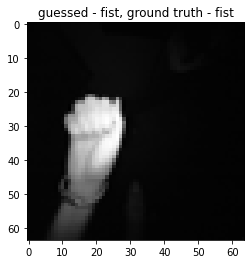

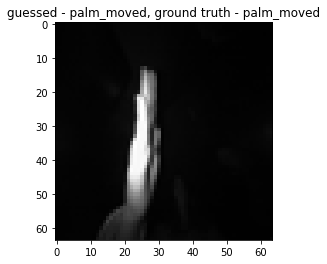

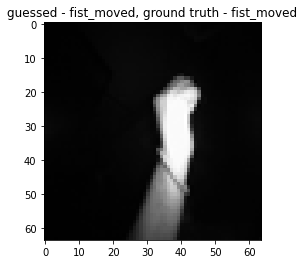

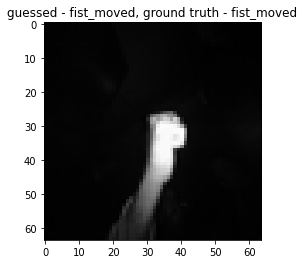

In [ ]:
with torch.no_grad():
  for i, data in enumerate(test_loader):
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = net_loaded(images)
      print(images.shape)
      print(outputs.shape)
      for j in range(outputs.shape[0]):
        guessed_label = outputs[j].argmax().item()
        guessed_label =  GESTURE_LABELS[(f'0{guessed_label + 1}', '10')[int(guessed_label == 9)]]
        truth_label = labels[j]
        truth_label =  GESTURE_LABELS[(f'0{truth_label + 1}', '10')[int(truth_label == 9)]]
        plt.title(f'guessed - {guessed_label}, ground truth - {truth_label}')
        plt.imshow(images[j].cpu().squeeze(), cmap='gray')
        plt.show()
      if i>4:
          break

## Работа с потоком

In [ ]:
!pip install opencv-python opencv-contrib-python

In [ ]:
!pip install facenet_pytorch

     |████████████████████████████████| 1.9MB 7.1MB/s 


In [ ]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN
from google.colab.patches import cv2_imshow

Так как работа идет в colab, входной и выходной потоки не стрим, а видео      
Для наглядности выведен каждый 20й кадр

In [ ]:
# Класс детектирования и обработки лица с веб-камеры 
class FaceDetector(object):

    def __init__(self, mtcnn, video_name, _net):
        # Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
        self.cap = cv2.VideoCapture(PATH_L5 + video_name) 
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.face_hb_detected = False
        self.emodel = _net

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs, landmarks, note, note_2='?'):
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # пишем на кадре какая эмоция распознана
                cv2.putText(frame, 
                    note, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                
                height, width = frame.shape[:2]
                cv2.putText(frame, 
                    note_2, (int(width/5), int(height/2)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Рисуем особенные точки
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            print('Something wrong im draw function!')

        return frame

            # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]-40):int(box[3]+40), 
                int(box[0]-40):int(box[2]+40)])
        return faces

        # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):
      counter = 0
      ok = False
      previous_gesture = ''
      frames = []
                  
      # Заходим в бесконечный цикл
      while True:
          # Считываем каждый новый кадр - frame
          # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
          ret, frame = self.cap.read()
          try:
              # детектируем расположение лица на кадре, вероятности насколько это лицо
              # и особенные точки лица
              boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
              if max(probs) > 0.99:
                self.face_hb_detected = True
                # Рисуем на кадре
                note = 'A face has been detected'
                note_2 = '?'
                if previous_gesture != '':
                  note_2 = f'Gesture: {previous_gesture}'  # Выводит название жеста
                if counter%20 == 0:
                  self._draw(frame, boxes, probs, landmarks, note, note_2)
                  cv2_imshow(frame)

                # frames.append(self._draw(frame, boxes, probs, landmarks, note, note_2))
                
                


          except Exception as e:
              print('Something wrong im main cycle!')
              print(f'error : {e}')
        
          
          # Функция, которая проверяет нажатие на клавишу 'q'
          # Если нажатие произошло - выход из цикла. Конец работы приложения
          if cv2.waitKey(1) & 0xFF == ord('q') or (ok and previous_gesture == 'palm_moved'):
              break

          # Если лицо было задетектировано, переходим к определению жеста
          if self.face_hb_detected:
            # Вырезаем ладонь из кадра
            height, width = frame.shape[:2]
            palm_image = frame[int(height/2):height, 0:int(width/2)]
            # Меняем размер изображения ладони для входа в нейронную сеть
            palm_image = cv2.resize(palm_image,(64,64))
            # Превращаем в 1-канальное серое изображение
            palm_image = cv2.cvtColor(palm_image, cv2.COLOR_BGR2GRAY)
            # Превращаем numpy-картинку вырезанного изображения в pytorch-тензор
            # cv2_imshow(palm_image)
            palm_image = np.asarray(palm_image).astype('float')
            palm_image = torch.as_tensor(palm_image)/255
            palm_image = palm_image.unsqueeze(0).to(self.device).float()
            # Загужаем наш тензор изображения в нейронную сеть и получаем предсказание
            outputs = self.emodel(palm_image[None, ...])
            # Интерпретируем предсказание как строку нашей эмоции
            guessed_label = outputs[0].argmax().item()
            guessed_label =  GESTURE_LABELS[(f'0{guessed_label + 1}', '10')[int(guessed_label == 9)]]

            # Реакции (остальные реакции см в коде выше)
            if guessed_label == 'ok':
              ok = True  # Прерывание выполнения программы после последовательности ok-palm
            previous_gesture = guessed_label
          counter += 1
            
      # out = cv2.VideoWriter(PATH_L5 + 'frames.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 20.0, frames[0].shape[:2])
      # for im in frames:
      #   out.write(im)
      # out.release()   

      # Очищаем все объекты opencv, что мы создали
      self.cap.release()
      cv2.destroyAllWindows()

In [ ]:
# Загружаем мтцнн
mtcnn = MTCNN()
video_name = 'gesture_video_2.mp4'
# Создаем объект нашего класса приложения
fcd = FaceDetector(mtcnn, video_name=video_name, _net=net_loaded)
# Запускаем
fcd.run()

Качество "живой" классификации очевидно оказалось ниже чем на test